In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, random
import pathlib
import glob

pd.set_option('display.max_columns', 100)

In [34]:
# Make a nested dictionary to easily access all data. first keys are cell-ids, second keys are charge, discharge or summary data
# Only c20 cycles are included at this point
cell_dict = {}

path_cells = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\IFE\interim"


for cell in os.listdir(path_cells)[1:]:
    
    # Make summary dataframes
    cell_dir = os.path.join(path_cells, cell)
    summary_file = os.path.join(cell_dir, os.listdir(cell_dir)[1])
    summary_df = pd.read_csv(summary_file, encoding = "ISO-8859-1", sep='\t')
    
    charge_cycles = []
    discharge_cycles = []
    cell_dict[cell] = {}
    
    c20_dir = os.path.join(path_cells, cell+'\C20_cycles')
    for charge_cycle in glob.glob(os.path.join(c20_dir, '*cha.txt')):
        charge_cycle_file = os.path.join(c20_dir, charge_cycle)
        charge_cycle_df = pd.read_csv(charge_cycle_file, encoding = "ISO-8859-1", sep='\t')
        charge_cycles.append(charge_cycle_df)
        
    for discharge_cycle in glob.glob(os.path.join(c20_dir, '*dch.txt')):
        discharge_cycle_file = os.path.join(c20_dir, discharge_cycle)
        discharge_cycle_df = pd.read_csv(discharge_cycle_file, encoding = "ISO-8859-1", sep='\t')
        discharge_cycles.append(discharge_cycle_df)

    # Add summary, charge cycles and discharge cycles to cell dictionary
    cell_dict[cell]['summary'] = summary_df
    cell_dict[cell]['charge'] = charge_cycles
    cell_dict[cell]['discharge'] = discharge_cycles

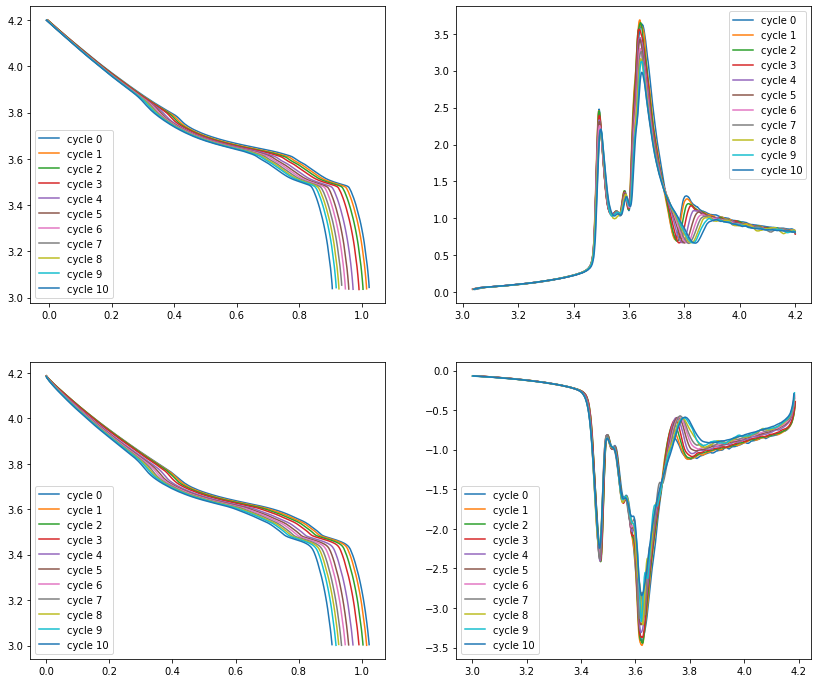

In [5]:
# Example of dictionary usage: Plot c20 cycles data for a representative cell

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
cell = cell_dict['Cell_ID_SK04A23557']
for i in range(len(cell['charge'])):
    ax[0,0].plot(cell['charge'][i]['Ah_balance (normalized)'], cell['charge'][i]['Voltage - fit (V)'], label='cycle ' + str(i))
    ax[0,0].legend()
    ax[0,1].plot(cell['charge'][i]['Voltage - fit (V)'], cell['charge'][i]['dQ/dV (1/V)'], label='cycle ' + str(i))
    ax[0,1].legend()
    
    ax[1,0].plot(cell['discharge'][i]['Ah_balance (normalized)'], cell['discharge'][i]['Voltage - fit (V)'], label='cycle ' + str(i))
    ax[1,0].legend()
    ax[1,1].plot(cell['discharge'][i]['Voltage - fit (V)'], cell['discharge'][i]['dQ/dV (1/V)'], label='cycle ' + str(i))
    ax[1,1].legend()

In [26]:
rep_cell_discharge = cell_dict['Cell_ID_SK04A22375']['discharge'][0]
rep_cell_discharge

,Ah_balance (normalized),Ah_balance (mAh),Voltage - fit (V),Voltage - interpolate (V),dQ/dV (1/V),Temperature (°C),Temperature - diff (°C),Current (C),R_DC 0ms (mOhm),R_DC 50ms (mOhm),R_DC 50 ms PEC (mOhm)
0,0.0001,4.17,4.185,4.1852,-0.5142,23.42,0.00,-0.05,NaN,NaN,NaN
1,0.0006,37.28,4.184,4.1839,-0.5277,23.41,-0.01,-0.05,NaN,NaN,NaN
2,0.0011,71.43,4.183,4.1825,-0.5394,23.40,-0.02,-0.05,NaN,NaN,NaN
3,0.0017,106.64,4.182,4.1818,-0.5550,23.41,-0.01,-0.05,NaN,NaN,NaN
4,0.0022,142.48,4.181,4.1809,-0.5652,23.42,0.00,-0.05,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1177,1.0215,65375.30,3.008,3.0080,-0.0685,23.56,0.14,-0.05,NaN,NaN,NaN
1178,1.0216,65379.73,3.007,3.0069,-0.0699,23.56,0.14,-0.05,NaN,NaN,NaN
1179,1.0216,65384.25,3.006,3.0059,-0.0713,23.56,0.14,-0.05,NaN,NaN,NaN
1180,1.0217,65388.85,3.005,3.0053,-0.0727,23.56,0.14,-0.05,NaN,NaN,NaN


<AxesSubplot:xlabel='Cycle - total - normalized'>

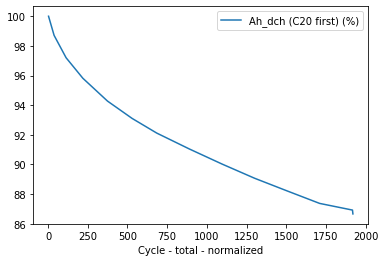

In [18]:
rep_cell_sum.loc[rep_cell_sum['Current_dch (C)'] == -0.05].plot(x='Cycle - total - normalized', y='Ah_dch (C20 first) (%)')

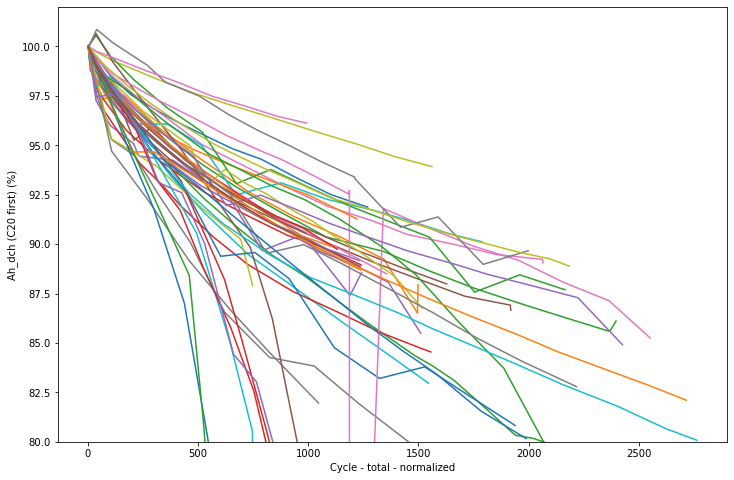

In [24]:
# Ser ikke bra ut. Finn ut hvilke celler som er syklet likt og få samlet dem

plt.figure(figsize=(12,8))
for cell in cell_dict.keys():
    summary = cell_dict[cell]['summary']
    c20 = summary.loc[summary['Current_dch (C)'] == -0.05]
    plt.plot(c20['Cycle - total - normalized'], c20['Ah_dch (C20 first) (%)'])
    plt.xlabel('Cycle - total - normalized')
    plt.ylabel('Ah_dch (C20 first) (%)')
    plt.ylim(80,102)

In [51]:
cycle_lives = np.zeros(len(cell_dict))
Qd_c20_fl = np.zeros(len(cell_dict))

for cell in cell_dict.keys():
    Qd_first = cell_dict[cell]['discharge'][0]['Ah_balance (normalized)'].values[:1159]
    Qd_last = cell_dict[cell]['discharge'][-1]['Ah_balance (normalized)'].values[:1159]
    Qd_diff = Qd_last - Qd_first
    
    summary = cell_dict[cell]['summary']
    c20 = summary.loc[summary['Current_dch (C)'] == -0.05]
    cl = c20.index[c20['Ah_dch (C20 first) (%)'] < 90].tolist()
    print(cl)
    
    #print(len(Qd_first), len(Qd_last), len(Qd_diff))

[1503, 1683, 1687]
[1946, 2258, 2571, 2888, 3208, 3532, 3580]
[1369, 1624]
[1902, 1989]
[1789, 2082, 2378, 2680, 2684]
[1277, 1517]
[687, 924, 1163, 1411, 1703]
[]
[804, 1040, 1280, 1525, 1771]
[]
[1143, 1382]
[1186, 1418, 1654, 1865, 2063, 2200, 2332, 2495, 2736, 2971, 3108, 3315]
[925, 1194, 1460, 1737, 1976, 2045]
[1354, 1544]
[1658, 1949, 2248]
[2577, 2877, 2881]
[496, 708, 926, 1192]
[954]
[]
[652, 826, 1003, 1239, 1479, 1723, 1971, 2223]
[]
[2081, 2338, 2599]
[1832]
[851, 1142, 1317, 1494, 1666]
[818, 940, 1031, 1140, 1324, 1332, 1333]
[3160, 4755, 5343, 5942, 6553, 7117]
[4867, 5457]
[3222, 3702, 4061]
[710, 840, 842, 962, 1058, 1123, 1175]
[492, 624, 699, 748]
[1267]
[3544, 3983, 4546, 5164, 5766]
[675, 772, 912, 1049, 1189, 1300, 1305, 1306]
[1994, 2287, 2510, 2806, 3104, 3403]
[]
[]
[896, 1088, 1289, 1530, 1774, 2021, 2272, 2581]
[5515, 5871, 6127]
[951, 1171, 1363, 1635, 1833, 2061, 2329, 2601, 2945, 3231, 3390]
[1074, 1258, 1445, 1635, 1827, 2085, 2348]
[1346, 1586, 1770, 2

In [68]:
c = list(cell_dict.keys())[35]
print(c)

Cell_ID_SK05A15632


<AxesSubplot:xlabel='Cycle - total - normalized'>

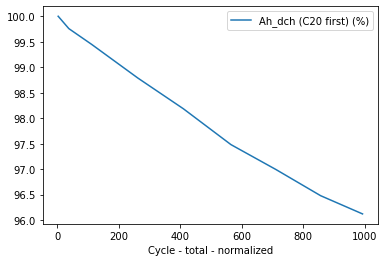

In [69]:
cell_summary = cell_dict[c]['summary']
cell_summary.loc[cell_summary['Current_dch (C)'] == -0.05].plot(x='Cycle - total - normalized', y='Ah_dch (C20 first) (%)')

In [ ]:
# for å sjekke cycle life på celle, finn indeks i listene over og sett inn i variabelen c


# Finn ut hva du skal sette verdien til for de cellene som ikke når 90%
# Finn ut hvordan fikse ulike lengder på Qd_first og Qd_last (foreløpig kutta til den korteste)
# Prøv enkel modell med antakelsene